In [233]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from utils_data_structures import col_prefixes

In [234]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

print(grouped_df['So_5_Scores_9'].isna().sum())
grouped_df['Position'].unique()

0


array(['Forward', 'Defender', 'Midfielder', 'Goalkeeper', 'Coach'],
      dtype=object)

In [235]:
midfielders_df = grouped_df[grouped_df['Position'] == 'Midfielder']
midfielders_df = midfielders_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])
midfielders_df = midfielders_df[:len(grouped_df) // 10]


In [236]:
midfielders_df.dtypes.value_counts()

float64    308
int64        4
Name: count, dtype: int64

In [237]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = midfielders_df.drop(columns=columns_to_drop)
y = midfielders_df[target_column]


In [238]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [239]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=750, learning_rate=0.01, max_depth=3, subsample=0.6, colsample_bytree=0.8, gamma=0.1, reg_alpha= 1.0, reg_lambda= 100.0 , random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_xgb_clipped)
print(f'r2: {r2}')

RMSE: 16.242105780027348
r2: 0.5749604562718121


In [240]:
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42, 
)

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_lgmb_clipped)
print(f'r2: {r2}')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6451
[LightGBM] [Info] Number of data points in the train set: 1244, number of used features: 191
[LightGBM] [Info] Start training from score 19.308787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

In [241]:

# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 16.639784947455592
r2: 0.5538919235920412


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.603e+05, tolerance: 7.982e+01
  model = cd_fast.enet_coordinate_descent(


In [242]:
with open('sorare_models/midfielders_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/midfielders_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/midfielders_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [243]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
4465,0.0,1.115986,2.071075,0.588359
534,0.0,0.339063,0.542329,0.000000
1166,0.0,0.334686,0.742507,2.395067
1486,41.4,19.059483,23.461229,30.025990
4588,0.0,0.664001,0.781831,1.732446
...,...,...,...,...
5019,0.0,6.912358,2.897714,5.525149
4950,0.0,30.276300,17.384393,29.080403
207,0.0,0.622207,0.555624,0.000000
4947,34.1,39.638680,30.639039,33.922593


In [244]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions,Average_Prediction
4465,0.0,1.115986,2.071075,0.588359,1.258473
534,0.0,0.339063,0.542329,0.000000,0.293797
1166,0.0,0.334686,0.742507,2.395067,1.157420
1486,41.4,19.059483,23.461229,30.025990,24.182234
4588,0.0,0.664001,0.781831,1.732446,1.059426
...,...,...,...,...,...
5019,0.0,6.912358,2.897714,5.525149,5.111740
4950,0.0,30.276300,17.384393,29.080403,25.580366
207,0.0,0.622207,0.555624,0.000000,0.392610
4947,34.1,39.638680,30.639039,33.922593,34.733437


In [245]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 16.17045884997501
r2: 0.5538919235920412


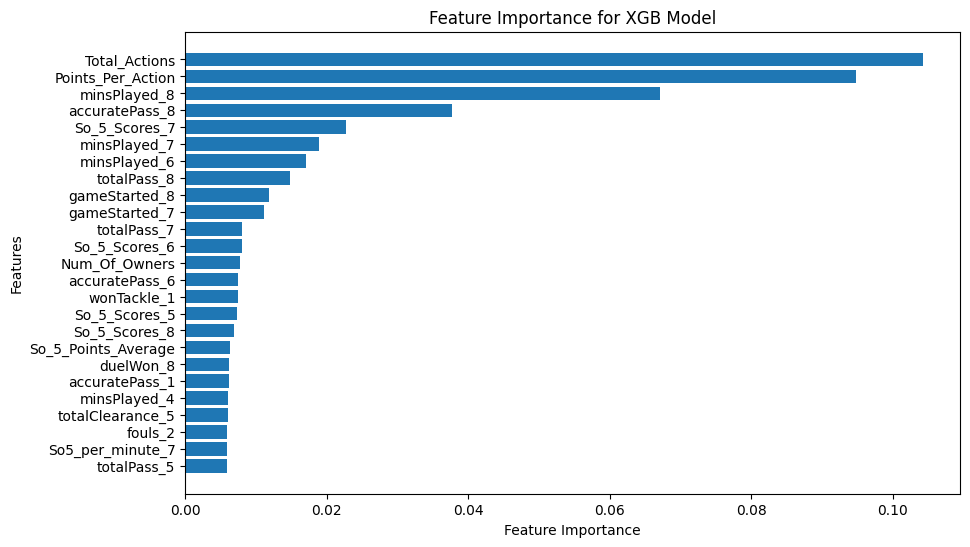

In [246]:

# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [247]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_midfielders_df = epl_teams[epl_teams['Position'] == 'Midfielder']

epl_midfielders_df = epl_midfielders_df.reset_index(drop=True)

In [248]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_midfielders = epl_midfielders_df.drop(columns=columns_to_drop)
y_test_midfielders = epl_midfielders_df[target_column]

In [249]:
with open('sorare_models/midfielders_xgb_model.pkl', 'rb') as file:
    midfielders_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/midfielders_lgbm_model.pkl', 'rb') as file:
    midfielders_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/midfielders_elastic_model.pkl', 'rb') as file:
    midfielders_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [250]:
xgb_predictions = midfielders_xgb_model_loaded.predict(X_test_midfielders)
lgbm_predictions = midfielders_lgbm_model_loaded.predict(X_test_midfielders)
elastic_predictions = midfielders_elastic_model_loaded.predict(X_test_midfielders)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_midfielders_df = pd.DataFrame(y_test_midfielders)

epl_midfielders_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_midfielders_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_midfielders_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_midfielders_df['sorare_predictions'] = epl_midfielders_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_midfielders_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,12.2,44.543579,26.14900,57.968947
1,35.9,24.044298,23.53588,13.320103
2,0.0,5.283266,0.00000,0.854546


In [251]:
y_true = epl_midfielders_df['So_5_Scores_9'].to_numpy()
y_pred = epl_midfielders_df['sorare_predictions'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_true, y_pred)
print(f'r2: {r2}')

RMSE: 17.498537417847214
r2: 0.520208428084709


In [252]:
xgb_scores = cross_val_score(midfielders_xgb_model_loaded, X, y)
lgbm_scores = cross_val_score(midfielders_lgbm_model_loaded, X, y)
elastic_scores = cross_val_score(midfielders_elastic_model_loaded, X, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6426
[LightGBM] [Info] Number of data points in the train set: 1244, number of used features: 191
[LightGBM] [Info] Start training from score 18.900027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.495e+05, tolerance: 7.868e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.475e+05, tolerance: 7.748e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

In [253]:
print("XGBoost scores:", xgb_scores)
print("Mean XGBoost score:", xgb_scores.mean())

print("LGBM scores:", lgbm_scores)
print("Mean LGBM score:", lgbm_scores.mean())

print("Elastic scores:", elastic_scores)
print("Mean Elastic score:", elastic_scores.mean())

XGBoost scores: [0.50983346 0.53373424 0.58174391 0.4865716  0.5339223 ]
Mean XGBoost score: 0.5291611019404018
LGBM scores: [0.49721188 0.48655415 0.52763779 0.44914814 0.51928748]
Mean LGBM score: 0.49596788631602245
Elastic scores: [0.46099411 0.50753931 0.51142788 0.44719611 0.51854213]
Mean Elastic score: 0.489139908006272


In [254]:
saved_midfielders_df = epl_midfielders_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
# saved_midfielders_df.to_csv('sorare_data/predictions/sorare_midfielders_predictions.csv', index=False)